<a href="https://colab.research.google.com/github/YS-JEOUNG/amazon-review-project/blob/main/code/final_3_bilstm_glove_w2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
# 기본
import pandas as pd
import numpy as np

# Warnings   
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

import re
import urllib.request       # 왜 넣는걸까

# 시각화
%matplotlib inline
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer, PorterStemmer

import string, unicodedata
from bs4 import BeautifulSoup

!pip install contractions
from contractions import contractions_dict

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import sklearn
import keras

In [ ]:
# 훈련
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix      
import seaborn as sns

In [ ]:
# pre-trained word2vec
import gensim

# Data

In [ ]:
# 파일 불러오기
total = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/final_data_clean.csv')

# final_2에서와 같은 전처리

In [ ]:
total = total.sort_values(by='rating_class')
total = total[:700_000]
total = total[['clean_text', 'rating_class']]
total['rating_class'] = total['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)
total = total.dropna(subset=['clean_text'])
total = sklearn.utils.shuffle(total)
total.head()

,clean_text,rating_class
1525011,two star look really great glitter come touch,0
1400231,one star amazon seriously need check review st...,0
1956602,three star not good wood buy thehem,1
1849075,christmas ornament make last year daughter fin...,1
1648927,pin really appreciate awesome share thehem fri...,1


In [ ]:
X = total['clean_text']
y = total['rating_class']

In [ ]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [ ]:
# 등장 빈도수가 15 미만인 단어들이 차지하는 비중
threshold = 15
total_cnt = len(word_index)
rare_cnt = 0      # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0    # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0     # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수 > key, value
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합의 크기:', total_cnt)
print(f'등장 빈도가 {threshold}번 미만인 희귀 단어의 수:', rare_cnt)
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq) * 100)

단어 집합의 크기: 132670
등장 빈도가 15번 미만인 희귀 단어의 수: 119516
단어 집합에서 희귀 단어의 비율: 90.08517373935328
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7197218589865317


In [ ]:
# 등장 빈도수가 15 미만인 단어는 제거
# 0번 패딩 토큰을 고려하여 +1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기:', vocab_size)
# 이렇게 하면 단어집합이 작아져 걸리는 시간이 줄어든다# 등장 빈도수가 15 미만인 단어는 제거
# 0번 패딩 토큰을 고려하여 +1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기:', vocab_size)
# 이렇게 하면 단어집합이 작아져 걸리는 시간이 줄어든다

단어 집합의 크기: 13155
단어 집합의 크기: 13155


In [ ]:
# 토큰화
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [ ]:
# 패딩
X = pad_sequences(X, maxlen=100)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
X_train.shape, X_test.shape

((524971, 100), (174991, 100))

In [ ]:
y_train.shape, y_test.shape

((524971,), (174991,))

# BiLSTM

## 256

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100, dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/100


In [ ]:
best_model = load_model('best_model.h5')
print('accuracy:', best_model.evaluate(X_test, y_test)[1])

In [ ]:
import keras

In [ ]:
import keras.backend as K
from keras.callbacks import Callback

In [ ]:
class lrfinder(Callback):
    """
    A simple callback for finding the optimal learning rate range for your model and dataset.
    # min_lr: the lower bound of the learning rate range for the experiment.
    # max_lr: the upper bound of the learning rate range for the experiment.
    # steps_per_epoch: number of mini-batches in the dataset. calculated as `np.ceil(epoch_size/batch_size)`.
    # epochs: number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient.
    """
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}

    def clr(self):
        """ Calculate the learning rate."""
        x = self.iteration / self.total_iterations
        return self.min_lr + (self.max_lr-self.min_lr)*x

    def on_train_begin(self, logs=None):
        """ Initialize the learning rate to the minimum value at the start of training."""
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)

    def on_batch_end(self, epoch, logs=None):
        """ Record previous batch statistics and update the learning rate."""
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

    def plot_lr(self):
        """ Helper function to quickly inspect the learning rate schedule."""
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('iteration')
        plt.ylabel('learning rate')
        plt.show()

    def plot_loss(self):
        """ Helper function to quickly observe the learning rate experiment results."""
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

In [ ]:
lr_finder = lrfinder(steps_per_epoch=np.ceil(3/256), epochs=3)

In [ ]:
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    """Wrapper function to create a LearningRateScheduler with step decay schedule."""
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history = model.fit(X_train, y_train, epochs=20, callbacks=[lr_sched], batch_size=256, validation_split=0.2)

Epoch 1/20
1641/1641 [==============================] - 74s 38ms/step - loss: 0.4004 - acc: 0.7994 - val_loss: 0.1802 - val_acc: 0.9315
Epoch 2/20
1641/1641 [==============================] - 62s 38ms/step - loss: 0.1757 - acc: 0.9344 - val_loss: 0.1692 - val_acc: 0.9355
Epoch 3/20
1641/1641 [==============================] - 62s 38ms/step - loss: 0.1617 - acc: 0.9392 - val_loss: 0.1651 - val_acc: 0.9374
Epoch 4/20
1641/1641 [==============================] - 63s 38ms/step - loss: 0.1558 - acc: 0.9414 - val_loss: 0.1611 - val_acc: 0.9381
Epoch 5/20
1641/1641 [==============================] - 63s 39ms/step - loss: 0.1519 - acc: 0.9430 - val_loss: 0.1596 - val_acc: 0.9388
Epoch 6/20
1641/1641 [==============================] - 63s 39ms/step - loss: 0.1472 - acc: 0.9447 - val_loss: 0.1591 - val_acc: 0.9385
Epoch 7/20
1641/1641 [==============================] - 64s 39ms/step - loss: 0.1446 - acc: 0.9451 - val_loss: 0.1562 - val_acc: 0.9398
Epoch 8/20
1641/1641 [==========================

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer=adam, loss='binary_crossentropy', metrics='acc')
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/100
1641/1641 [==============================] - 72s 37ms/step - loss: 0.4027 - acc: 0.7987 - val_loss: 0.1883 - val_acc: 0.9313

Epoch 00001: val_acc improved from -inf to 0.93126, saving model to best_model.h5
Epoch 2/100
1641/1641 [==============================] - 60s 37ms/step - loss: 0.1754 - acc: 0.9360 - val_loss: 0.1688 - val_acc: 0.9363

Epoch 00002: val_acc improved from 0.93126 to 0.93635, saving model to best_model.h5
Epoch 3/100
1641/1641 [==============================] - 61s 37ms/step - loss: 0.1629 - acc: 0.9395 - val_loss: 0.1639 - val_acc: 0.9375

Epoch 00003: val_acc improved from 0.93635 to 0.93749, saving model to best_model.h5
Epoch 4/100
1641/1641 [==============================] - 61s 37ms/step - loss: 0.1520 - acc: 0.9432 - val_loss: 0.1599 - val_acc: 0.9387

Epoch 00004: val_acc improved from 0.93749 to 0.93869, saving model to best_model.h5
Epoch 5/100
1641/1641 [==============================] - 61s 37ms/step - loss: 0.1482 - acc: 0.9444 - val_loss:

In [ ]:
best_model = load_model('best_model.h5')
print('accuracy:', best_model.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 32s 6ms/step - loss: 0.1540 - acc: 0.9406
accuracy: 0.9405626654624939


In [ ]:
adam2 = keras.optimizers.Adam(learning_rate=0.0005)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=adam2, loss='binary_crossentropy', metrics='acc')
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/100
1641/1641 [==============================] - 64s 37ms/step - loss: 0.2808 - acc: 0.8741 - val_loss: 0.1585 - val_acc: 0.9380

Epoch 00001: val_acc improved from -inf to 0.93803, saving model to best_model2.h5
Epoch 2/100
1641/1641 [==============================] - 60s 37ms/step - loss: 0.1475 - acc: 0.9432 - val_loss: 0.1498 - val_acc: 0.9425

Epoch 00002: val_acc improved from 0.93803 to 0.94250, saving model to best_model2.h5
Epoch 3/100
1641/1641 [==============================] - 61s 37ms/step - loss: 0.1315 - acc: 0.9495 - val_loss: 0.1471 - val_acc: 0.9445

Epoch 00003: val_acc improved from 0.94250 to 0.94454, saving model to best_model2.h5
Epoch 4/100
1641/1641 [==============================] - 62s 38ms/step - loss: 0.1178 - acc: 0.9551 - val_loss: 0.1478 - val_acc: 0.9452

Epoch 00004: val_acc improved from 0.94454 to 0.94521, saving model to best_model2.h5
Epoch 5/100
1641/1641 [==============================] - 61s 37ms/step - loss: 0.1069 - acc: 0.9599 - val_l

In [ ]:
best_model2 = load_model('best_model2.h5')
print('accuracy:', best_model2.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 33s 6ms/step - loss: 0.1461 - acc: 0.9448
accuracy: 0.9448200464248657


### 위에는 그냥 해본거. 이게 진짜.

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/100
1641/1641 [==============================] - 64s 38ms/step - loss: 0.2524 - acc: 0.8921 - val_loss: 0.1496 - val_acc: 0.9418

Epoch 00001: val_acc improved from -inf to 0.94177, saving model to best_model3.h5
Epoch 2/100
1641/1641 [==============================] - 61s 37ms/step - loss: 0.1366 - acc: 0.9479 - val_loss: 0.1440 - val_acc: 0.9467

Epoch 00002: val_acc improved from 0.94177 to 0.94666, saving model to best_model3.h5
Epoch 3/100
1641/1641 [==============================] - 61s 37ms/step - loss: 0.1195 - acc: 0.9551 - val_loss: 0.1442 - val_acc: 0.9462

Epoch 00003: val_acc did not improve from 0.94666
Epoch 4/100
1641/1641 [==============================] - 61s 37ms/step - loss: 0.1061 - acc: 0.9598 - val_loss: 0.1470 - val_acc: 0.9452

Epoch 00004: val_acc did not improve from 0.94666
Epoch 5/100
1641/1641 [==============================] - 61s 37ms/step - loss: 0.0955 - acc: 0.9642 - val_loss: 0.1547 - val_acc: 0.9434

Epoch 00005: val_acc did not improve from

In [ ]:
best_model3 = load_model('best_model3.h5')
print('accuracy:', best_model3.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 33s 6ms/step - loss: 0.1427 - acc: 0.9457
accuracy: 0.9457343816757202


In [ ]:
hist = pd.DataFrame(history.history)

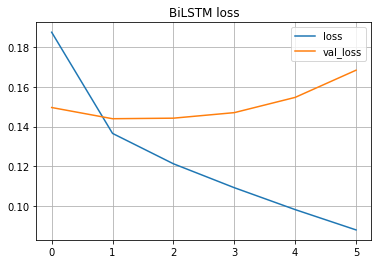

In [ ]:
hist[['loss', 'val_loss']].plot()
plt.title('BiLSTM loss')
plt.grid()
plt.show()

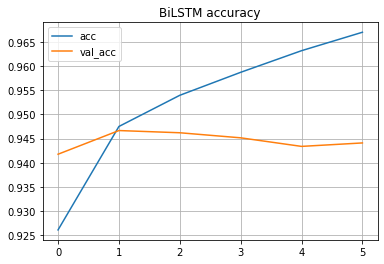

In [ ]:
hist[['acc', 'val_acc']].plot()
plt.title('BiLSTM accuracy')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = best_model3.evaluate(X_test, y_test, verbose=1)
pred = best_model3.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 32s 6ms/step - loss: 0.1427 - acc: 0.9457
model accuracy: 0.9457343816757202


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)

In [ ]:
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])

# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

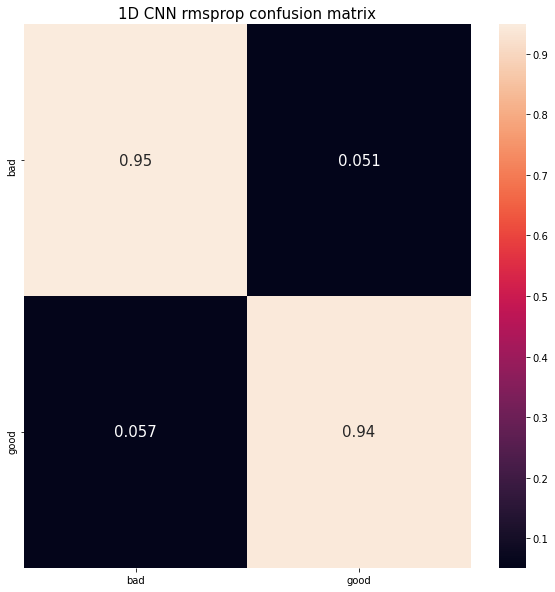

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('1D CNN rmsprop confusion matrix', fontsize=15)
plt.show()

## 512

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 100))
model2.add(Bidirectional(LSTM(100)))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model4.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history2 = model2.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=512, validation_split=0.2)

Epoch 1/100
821/821 [==============================] - 50s 57ms/step - loss: 0.2927 - acc: 0.8689 - val_loss: 0.1571 - val_acc: 0.9391

Epoch 00001: val_acc improved from -inf to 0.93905, saving model to best_model4.h5
Epoch 2/100
821/821 [==============================] - 47s 57ms/step - loss: 0.1444 - acc: 0.9441 - val_loss: 0.1462 - val_acc: 0.9432

Epoch 00002: val_acc improved from 0.93905 to 0.94323, saving model to best_model4.h5
Epoch 3/100
821/821 [==============================] - 47s 57ms/step - loss: 0.1278 - acc: 0.9511 - val_loss: 0.1466 - val_acc: 0.9448

Epoch 00003: val_acc improved from 0.94323 to 0.94478, saving model to best_model4.h5
Epoch 4/100
821/821 [==============================] - 47s 57ms/step - loss: 0.1136 - acc: 0.9571 - val_loss: 0.1464 - val_acc: 0.9444

Epoch 00004: val_acc did not improve from 0.94478
Epoch 5/100
821/821 [==============================] - 47s 57ms/step - loss: 0.1037 - acc: 0.9610 - val_loss: 0.1563 - val_acc: 0.9430

Epoch 00005: va

In [ ]:
best_model4 = load_model('best_model4.h5')
print('accuracy:', best_model4.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 33s 6ms/step - loss: 0.1460 - acc: 0.9445
accuracy: 0.9444771409034729


In [ ]:
hist2 = pd.DataFrame(history2.history)

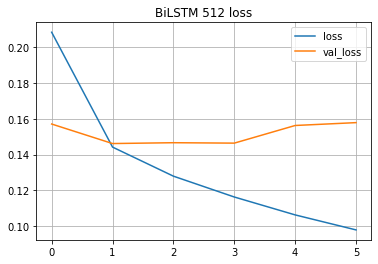

In [ ]:
hist2[['loss', 'val_loss']].plot()
plt.title('BiLSTM 512 loss')
plt.grid()
plt.show()

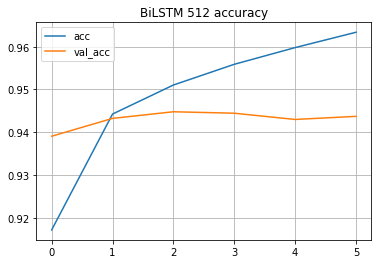

In [ ]:
hist2[['acc', 'val_acc']].plot()
plt.title('BiLSTM 512 accuracy')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = best_model4.evaluate(X_test, y_test, verbose=1)
pred = best_model4.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 32s 6ms/step - loss: 0.1460 - acc: 0.9445
model accuracy: 0.9444771409034729


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)

In [ ]:
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])

# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

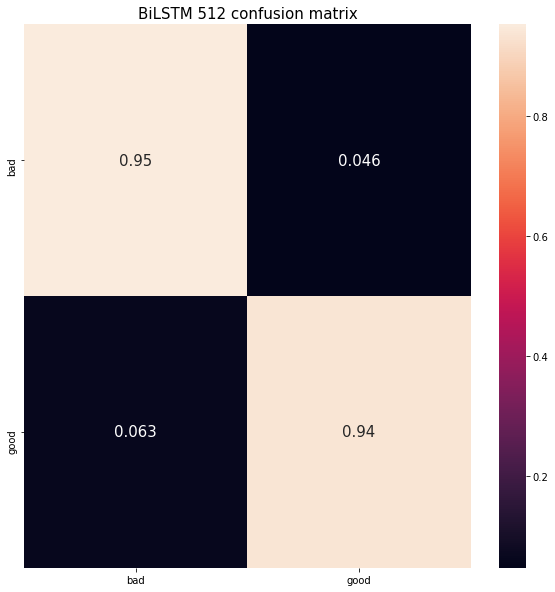

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('BiLSTM 512 confusion matrix', fontsize=15)
plt.show()

# GloVe

## 100d

### 32

In [ ]:
# GloVe 100d 파일 파싱하기(50, 100, 200, 300 중 일단 예제대로 해보겠음)
embeddings_index = {}
f = open('/content/drive/MyDrive/Colab Notebooks/project/data/glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
# GloVe 단어 임베딩 행렬 준비
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 된다.
            embedding_matrix[i] = embedding_vector

In [ ]:
# 모델 만들기
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=100))    # 100=maxlen
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# 사전 훈련된 단어 임베딩을 Embedding 층에 로드하기
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/100
13125/13125 [==============================] - 43s 3ms/step - loss: 0.3158 - acc: 0.8598 - val_loss: 0.2558 - val_acc: 0.8907

Epoch 00001: val_acc improved from -inf to 0.89068, saving model to best_model5.h5
Epoch 2/100
13125/13125 [==============================] - 43s 3ms/step - loss: 0.2310 - acc: 0.9017 - val_loss: 0.2453 - val_acc: 0.8952

Epoch 00002: val_acc improved from 0.89068 to 0.89517, saving model to best_model5.h5
Epoch 3/100
13125/13125 [==============================] - 43s 3ms/step - loss: 0.2066 - acc: 0.9133 - val_loss: 0.2407 - val_acc: 0.8978

Epoch 00003: val_acc improved from 0.89517 to 0.89781, saving model to best_model5.h5
Epoch 4/100
13125/13125 [==============================] - 43s 3ms/step - loss: 0.1901 - acc: 0.9212 - val_loss: 0.2482 - val_acc: 0.8972

Epoch 00004: val_acc did not improve from 0.89781
Epoch 5/100
13125/13125 [==============================] - 42s 3ms/step - loss: 0.1761 - acc: 0.9279 - val_loss: 0.2545 - val_acc: 0.8974



In [ ]:
best_model5 = load_model('best_model5.h5')
print('accuracy:', best_model5.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 11s 2ms/step - loss: 0.2432 - acc: 0.8970
accuracy: 0.8970061540603638


In [ ]:
hist = pd.DataFrame(history.history)

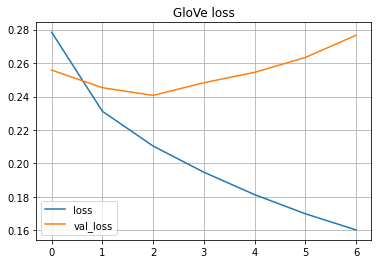

In [ ]:
hist[['loss', 'val_loss']].plot()
plt.title('GloVe loss')
plt.grid()
plt.show()

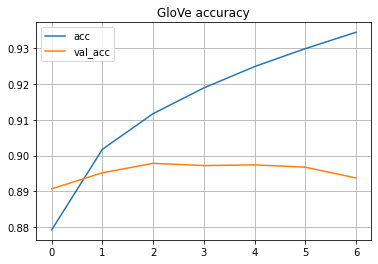

In [ ]:
hist[['acc', 'val_acc']].plot()
plt.title('GloVe accuracy')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = best_model5.evaluate(X_test, y_test, verbose=1)
pred = best_model5.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 11s 2ms/step - loss: 0.2432 - acc: 0.8970
model accuracy: 0.8970061540603638


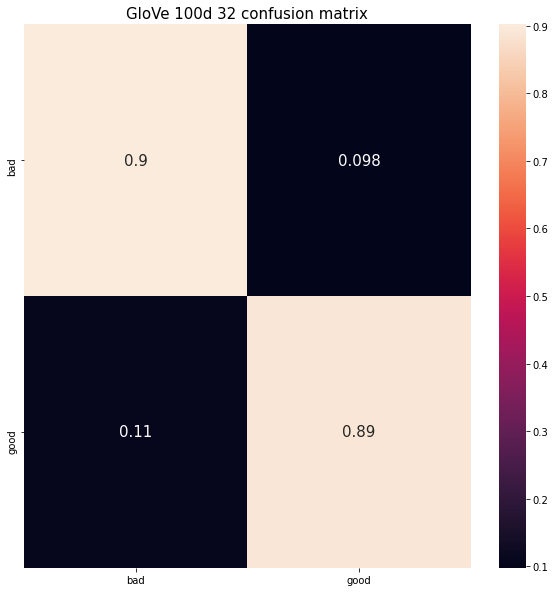

In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('GloVe 100d 32 confusion matrix', fontsize=15)
plt.show()

### 256

In [ ]:
# 모델 만들기
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))    # 100=maxlen
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model6.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history2 = model2.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/100
1641/1641 [==============================] - 10s 6ms/step - loss: 0.3467 - acc: 0.8450 - val_loss: 0.2606 - val_acc: 0.8901

Epoch 00001: val_acc improved from -inf to 0.89015, saving model to best_model6.h5
Epoch 2/100
1641/1641 [==============================] - 8s 5ms/step - loss: 0.2393 - acc: 0.8993 - val_loss: 0.2483 - val_acc: 0.8954

Epoch 00002: val_acc improved from 0.89015 to 0.89544, saving model to best_model6.h5
Epoch 3/100
1641/1641 [==============================] - 8s 5ms/step - loss: 0.2128 - acc: 0.9117 - val_loss: 0.2449 - val_acc: 0.8964

Epoch 00003: val_acc improved from 0.89544 to 0.89643, saving model to best_model6.h5
Epoch 4/100
1641/1641 [==============================] - 8s 5ms/step - loss: 0.1923 - acc: 0.9217 - val_loss: 0.2509 - val_acc: 0.8973

Epoch 00004: val_acc improved from 0.89643 to 0.89732, saving model to best_model6.h5
Epoch 5/100
1641/1641 [==============================] - 8s 5ms/step - loss: 0.1749 - acc: 0.9292 - val_loss: 0.25

In [ ]:
best_model6 = load_model('best_model6.h5')
print('accuracy:', best_model6.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 12s 2ms/step - loss: 0.2508 - acc: 0.8968
accuracy: 0.8968175649642944


In [ ]:
hist2 = pd.DataFrame(history2.history)

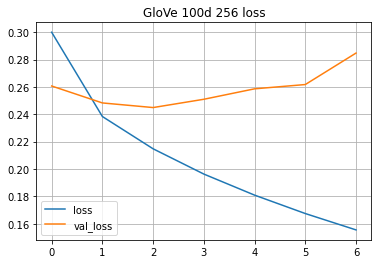

In [ ]:
hist2[['loss', 'val_loss']].plot()
plt.title('GloVe 100d 256 loss')
plt.grid()
plt.show()

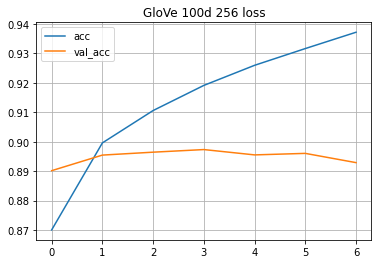

In [ ]:
hist2[['acc', 'val_acc']].plot()
plt.title('GloVe 100d 256 loss')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = best_model6.evaluate(X_test, y_test, verbose=1)
pred = best_model6.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 12s 2ms/step - loss: 0.2508 - acc: 0.8968
model accuracy: 0.8968175649642944


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])
# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

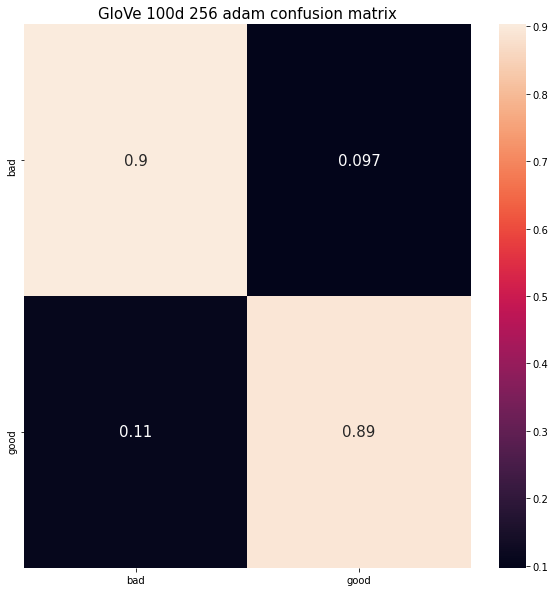

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('GloVe 100d 256 adam confusion matrix', fontsize=15)
plt.show()

### 512

In [ ]:
# 모델 만들기
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))    # 100=maxlen
model3.add(Flatten())
model3.add(Dense(32, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model7.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history3 = model3.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=512, validation_split=0.2)

Epoch 1/100
821/821 [==============================] - 7s 8ms/step - loss: 0.3668 - acc: 0.8352 - val_loss: 0.2738 - val_acc: 0.8836

Epoch 00001: val_acc improved from -inf to 0.88358, saving model to best_model7.h5
Epoch 2/100
821/821 [==============================] - 6s 7ms/step - loss: 0.2530 - acc: 0.8930 - val_loss: 0.2528 - val_acc: 0.8931

Epoch 00002: val_acc improved from 0.88358 to 0.89311, saving model to best_model7.h5
Epoch 3/100
821/821 [==============================] - 6s 7ms/step - loss: 0.2219 - acc: 0.9081 - val_loss: 0.2453 - val_acc: 0.8970

Epoch 00003: val_acc improved from 0.89311 to 0.89700, saving model to best_model7.h5
Epoch 4/100
821/821 [==============================] - 6s 7ms/step - loss: 0.1997 - acc: 0.9186 - val_loss: 0.2479 - val_acc: 0.8960

Epoch 00004: val_acc did not improve from 0.89700
Epoch 5/100
821/821 [==============================] - 6s 7ms/step - loss: 0.1812 - acc: 0.9270 - val_loss: 0.2532 - val_acc: 0.8971

Epoch 00005: val_acc impr

In [ ]:
best_model7 = load_model('best_model7.h5')
print('accuracy:', best_model7.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 12s 2ms/step - loss: 0.2529 - acc: 0.8980
accuracy: 0.8980119228363037


In [ ]:
hist3 = pd.DataFrame(history3.history)

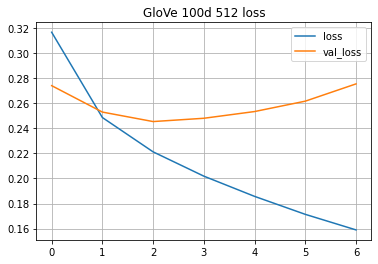

In [ ]:
hist3[['loss', 'val_loss']].plot()
plt.title('GloVe 100d 512 loss')
plt.grid()
plt.show()

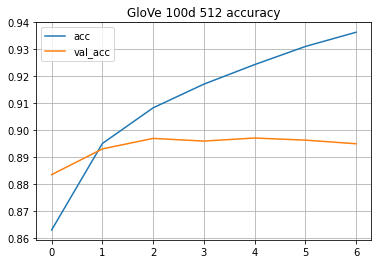

In [ ]:
hist3[['acc', 'val_acc']].plot()
plt.title('GloVe 100d 512 accuracy')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = best_model7.evaluate(X_test, y_test, verbose=1)
pred = best_model7.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 12s 2ms/step - loss: 0.2529 - acc: 0.8980
model accuracy: 0.8980119228363037


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])
# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

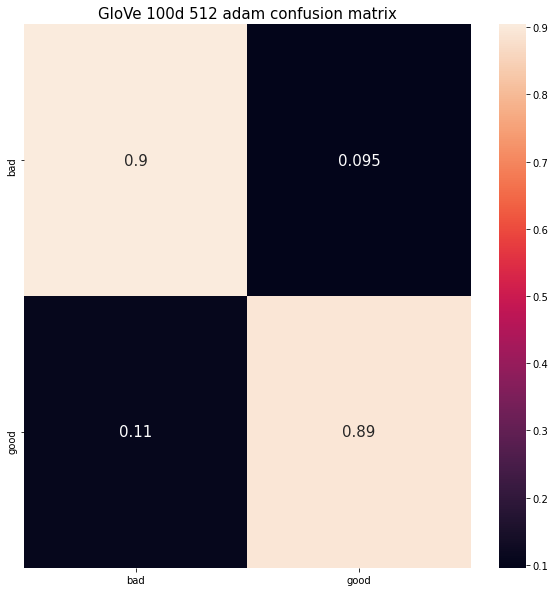

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('GloVe 100d 512 adam confusion matrix', fontsize=15)
plt.show()

## 300d

In [ ]:
# GloVe 300d 파일 파싱하기
embeddings_index = {}
f = open('/content/drive/MyDrive/Colab Notebooks/project/data/glove.6B.300d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
# GloVe 단어 임베딩 행렬 준비
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 된다.
            embedding_matrix[i] = embedding_vector

### 32

In [ ]:
# 모델 만들기
model_300d = Sequential()
# 사전훈련된 임베딩을 사용하므로 별도의 훈련을 하지 않기 위해 trainable=False
model_300d.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))    # 100=maxlen
model_300d.add(Flatten())
model_300d.add(Dense(32, activation='relu'))
model_300d.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model8.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model_300d.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history_300d = model_300d.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/100
13125/13125 [==============================] - 48s 4ms/step - loss: 0.2783 - acc: 0.8795 - val_loss: 0.2241 - val_acc: 0.9056

Epoch 00001: val_acc improved from -inf to 0.90559, saving model to best_model8.h5
Epoch 2/100
13125/13125 [==============================] - 47s 4ms/step - loss: 0.1905 - acc: 0.9211 - val_loss: 0.2179 - val_acc: 0.9096

Epoch 00002: val_acc improved from 0.90559 to 0.90957, saving model to best_model8.h5
Epoch 3/100
13125/13125 [==============================] - 47s 4ms/step - loss: 0.1578 - acc: 0.9362 - val_loss: 0.2364 - val_acc: 0.9064

Epoch 00003: val_acc did not improve from 0.90957
Epoch 4/100
13125/13125 [==============================] - 47s 4ms/step - loss: 0.1305 - acc: 0.9478 - val_loss: 0.2621 - val_acc: 0.9029

Epoch 00004: val_acc did not improve from 0.90957
Epoch 5/100
13125/13125 [==============================] - 47s 4ms/step - loss: 0.1084 - acc: 0.9574 - val_loss: 0.2853 - val_acc: 0.9024

Epoch 00005: val_acc did not improve

In [ ]:
best_model_300d = load_model('best_model8.h5')
print('accuracy:', best_model_300d.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 14s 3ms/step - loss: 0.2189 - acc: 0.9093
accuracy: 0.9093153476715088


In [ ]:
hist_300d = pd.DataFrame(history_300d.history)

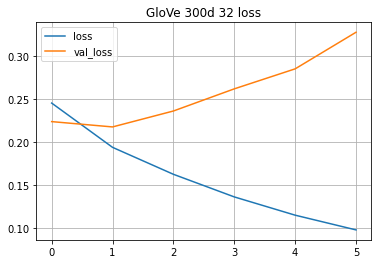

In [ ]:
hist_300d[['loss', 'val_loss']].plot()
plt.title('GloVe 300d 32 loss')
plt.grid()
plt.show()

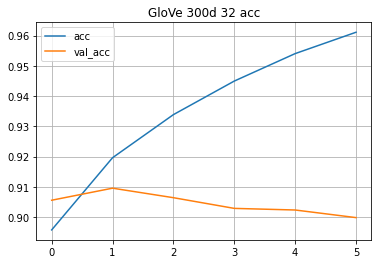

In [ ]:
hist_300d[['acc', 'val_acc']].plot()
plt.title('GloVe 300d 32 acc')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = best_model_300d.evaluate(X_test, y_test, verbose=1)
pred = best_model_300d.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 14s 2ms/step - loss: 0.2189 - acc: 0.9093
model accuracy: 0.9093153476715088


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)

In [ ]:
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])

# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

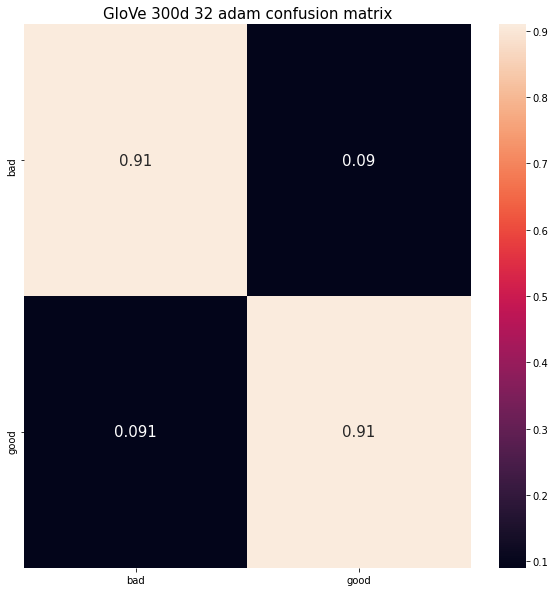

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('GloVe 300d 32 adam confusion matrix', fontsize=15)
plt.show()

### 256

In [ ]:
# 모델 만들기
model_300d_2 = Sequential()
# 사전훈련된 임베딩을 사용하므로 별도의 훈련을 하지 않기 위해 trainable=False
model_300d_2.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))    # 100=maxlen
model_300d_2.add(Flatten())
model_300d_2.add(Dense(32, activation='relu'))
model_300d_2.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model9.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model_300d_2.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history_300d_2 = model_300d_2.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/100
1641/1641 [==============================] - 19s 11ms/step - loss: 0.2977 - acc: 0.8705 - val_loss: 0.2264 - val_acc: 0.9051

Epoch 00001: val_acc improved from -inf to 0.90508, saving model to best_model9.h5
Epoch 2/100
1641/1641 [==============================] - 18s 11ms/step - loss: 0.1943 - acc: 0.9203 - val_loss: 0.2233 - val_acc: 0.9069

Epoch 00002: val_acc improved from 0.90508 to 0.90688, saving model to best_model9.h5
Epoch 3/100
1641/1641 [==============================] - 18s 11ms/step - loss: 0.1623 - acc: 0.9359 - val_loss: 0.2326 - val_acc: 0.9069

Epoch 00003: val_acc did not improve from 0.90688
Epoch 4/100
1641/1641 [==============================] - 19s 12ms/step - loss: 0.1351 - acc: 0.9473 - val_loss: 0.2530 - val_acc: 0.9043

Epoch 00004: val_acc did not improve from 0.90688
Epoch 5/100
1641/1641 [==============================] - 19s 12ms/step - loss: 0.1117 - acc: 0.9572 - val_loss: 0.2870 - val_acc: 0.9019

Epoch 00005: val_acc did not improve from

In [ ]:
best_model_300d_2 = load_model('best_model9.h5')
print('accuracy:', best_model_300d_2.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 14s 3ms/step - loss: 0.2225 - acc: 0.9071
accuracy: 0.90705806016922


In [ ]:
hist_300d_2 = pd.DataFrame(history_300d_2.history)

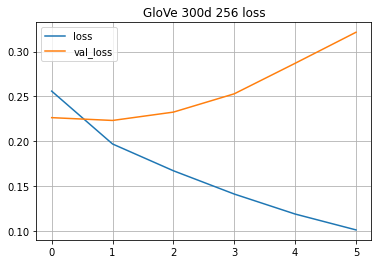

In [ ]:
hist_300d_2[['loss', 'val_loss']].plot()
plt.title('GloVe 300d 256 loss')
plt.grid()
plt.show()

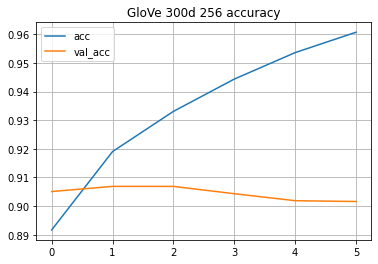

In [ ]:
hist_300d_2[['acc', 'val_acc']].plot()
plt.title('GloVe 300d 256 accuracy')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = best_model_300d_2.evaluate(X_test, y_test, verbose=1)
pred = best_model_300d_2.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 14s 3ms/step - loss: 0.2225 - acc: 0.9071
model accuracy: 0.90705806016922


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])
# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

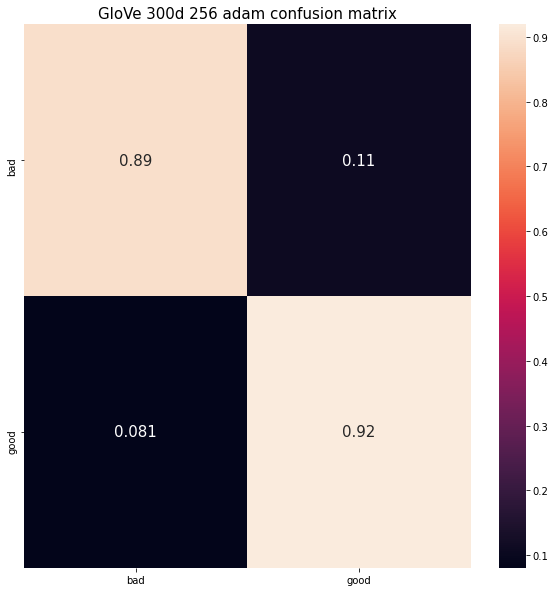

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('GloVe 300d 256 adam confusion matrix', fontsize=15)
plt.show()

### 512

In [ ]:
# 모델 만들기
model_300d_3 = Sequential()
# 사전훈련된 임베딩을 사용하므로 별도의 훈련을 하지 않기 위해 trainable=False
model_300d_3.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))    # 100=maxlen
model_300d_3.add(Flatten())
model_300d_3.add(Dense(32, activation='relu'))
model_300d_3.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model10.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model_300d_3.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history_300d_3 = model_300d_3.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=512, validation_split=0.2)

Epoch 1/100
821/821 [==============================] - 18s 22ms/step - loss: 0.3084 - acc: 0.8634 - val_loss: 0.2324 - val_acc: 0.9025

Epoch 00001: val_acc improved from -inf to 0.90251, saving model to best_model10.h5
Epoch 2/100
821/821 [==============================] - 18s 21ms/step - loss: 0.1979 - acc: 0.9200 - val_loss: 0.2223 - val_acc: 0.9073

Epoch 00002: val_acc improved from 0.90251 to 0.90735, saving model to best_model10.h5
Epoch 3/100
821/821 [==============================] - 18s 21ms/step - loss: 0.1672 - acc: 0.9339 - val_loss: 0.2304 - val_acc: 0.9074

Epoch 00003: val_acc improved from 0.90735 to 0.90744, saving model to best_model10.h5
Epoch 4/100
821/821 [==============================] - 18s 21ms/step - loss: 0.1389 - acc: 0.9461 - val_loss: 0.2452 - val_acc: 0.9065

Epoch 00004: val_acc did not improve from 0.90744
Epoch 5/100
821/821 [==============================] - 17s 21ms/step - loss: 0.1159 - acc: 0.9561 - val_loss: 0.2683 - val_acc: 0.9045

Epoch 00005:

In [ ]:
best_model_300d_3 = load_model('best_model10.h5')
print('accuracy:', best_model_300d_3.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 14s 3ms/step - loss: 0.2277 - acc: 0.9084
accuracy: 0.9084181189537048


In [ ]:
hist_300d_3 = pd.DataFrame(history_300d_3.history)

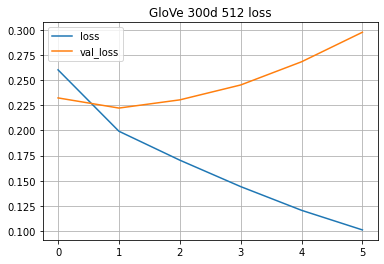

In [ ]:
hist_300d_3[['loss', 'val_loss']].plot()
plt.title('GloVe 300d 512 loss')
plt.grid()
plt.show()

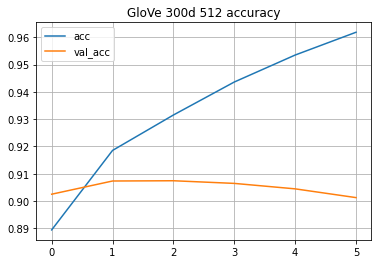

In [ ]:
hist_300d_3[['acc', 'val_acc']].plot()
plt.title('GloVe 300d 512 accuracy')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = best_model_300d_3.evaluate(X_test, y_test, verbose=1)
pred = best_model_300d_3.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 14s 3ms/step - loss: 0.2277 - acc: 0.9084
model accuracy: 0.9084181189537048


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])
# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

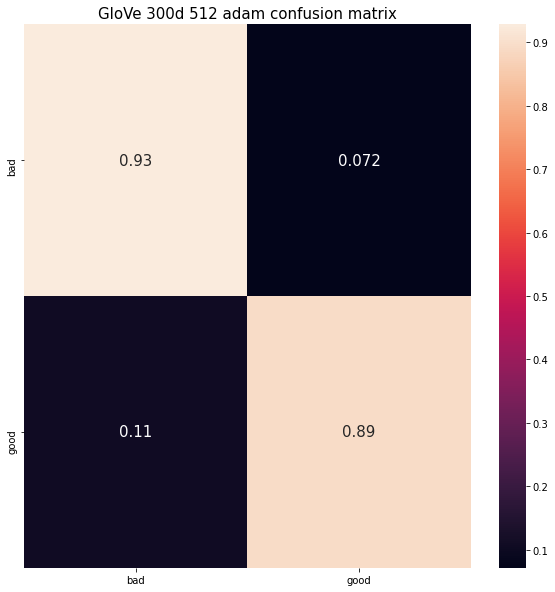

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('GloVe 300d 512 adam confusion matrix', fontsize=15)
plt.show()

# 사전훈련된 Word2Vec

In [ ]:
# 구글의 사전훈련된 모델 로드
# 여러 개 있다고 하는데 300을 많이들 사용하는 것 같아서 그거로
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/project/data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
word2vec_model.vectors.shape

(3000000, 300)

In [ ]:
# Word2Vec 단어 임베딩 행렬 준비
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 된다.
            embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(13155, 300)

### 32

In [ ]:
model_w2v_32 = Sequential()
model_w2v_32.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))
model_w2v_32.add(Bidirectional(LSTM(100)))
model_w2v_32.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model11.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model_w2v_32.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history_w2v_32 = model_w2v_32.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/100
13125/13125 [==============================] - 183s 14ms/step - loss: 0.1942 - acc: 0.9211 - val_loss: 0.1502 - val_acc: 0.9406

Epoch 00001: val_acc improved from -inf to 0.94057, saving model to best_model11.h5
Epoch 2/100
13125/13125 [==============================] - 178s 14ms/step - loss: 0.1354 - acc: 0.9476 - val_loss: 0.1382 - val_acc: 0.9462

Epoch 00002: val_acc improved from 0.94057 to 0.94623, saving model to best_model11.h5
Epoch 3/100
13125/13125 [==============================] - 177s 14ms/step - loss: 0.1213 - acc: 0.9539 - val_loss: 0.1389 - val_acc: 0.9464

Epoch 00003: val_acc improved from 0.94623 to 0.94644, saving model to best_model11.h5
Epoch 4/100
13125/13125 [==============================] - 177s 14ms/step - loss: 0.1065 - acc: 0.9598 - val_loss: 0.1427 - val_acc: 0.9458

Epoch 00004: val_acc did not improve from 0.94644
Epoch 5/100
13125/13125 [==============================] - 178s 14ms/step - loss: 0.0941 - acc: 0.9649 - val_loss: 0.1472 - val_

In [ ]:
best_model_w2v_32 = load_model('best_model11.h5')
print('accuracy:', best_model_w2v_32.evaluate(X_test, y_test)[1])
print('loss:', best_model_w2v_32.evaluate(X_test, y_test)[0])

5469/5469 [==============================] - 34s 6ms/step - loss: 0.1381 - acc: 0.9468
accuracy: 0.9467572569847107
5469/5469 [==============================] - 34s 6ms/step - loss: 0.1381 - acc: 0.9468
loss: 0.13812299072742462


In [ ]:
hist_w2v_32 = pd.DataFrame(history_w2v_32.history)

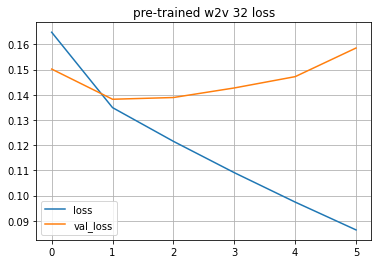

In [ ]:
hist_w2v_32[['loss', 'val_loss']].plot()
plt.title('pre-trained w2v 32 loss')
plt.grid()
plt.show()

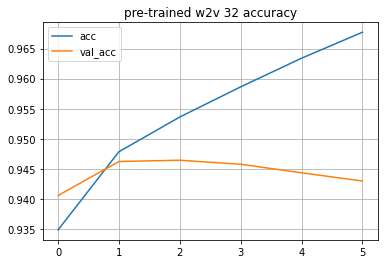

In [ ]:
hist_w2v_32[['acc', 'val_acc']].plot()
plt.title('pre-trained w2v 32 accuracy')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = best_model_w2v_32.evaluate(X_test, y_test, verbose=1)
pred = best_model_w2v_32.predict(X_test)
print('model accuracy:', test_acc)
print('model loss:', test_loss)

5469/5469 [==============================] - 34s 6ms/step - loss: 0.1381 - acc: 0.9468
model accuracy: 0.9467572569847107
model loss: 0.13812299072742462


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])
# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

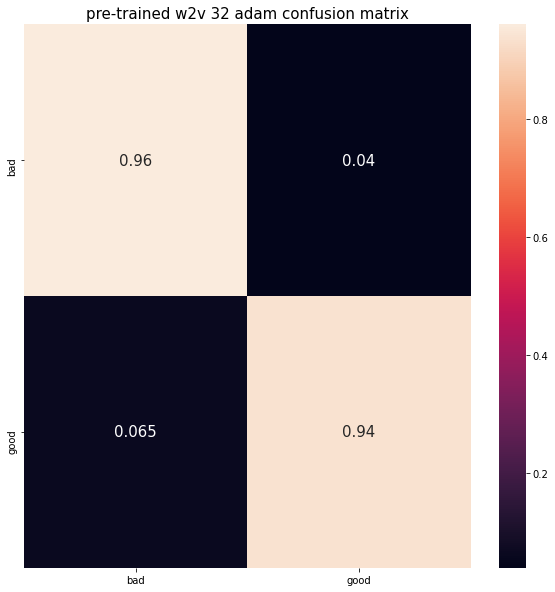

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('pre-trained w2v 32 adam confusion matrix', fontsize=15)
plt.show()

### 256

In [ ]:
# 모델에 적용(BiLSTM이 지금까지 결과가 제일 좋았던 것 같아서 그거로 해보겠음)
model_w2v = Sequential()
model_w2v.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))
model_w2v.add(Bidirectional(LSTM(100)))
model_w2v.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model12.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
# 근데 위에서는 rmsprop으로 했지만 adam으로 하겠음
model_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history_w2v = model_w2v.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/100
1641/1641 [==============================] - 65s 38ms/step - loss: 0.2371 - acc: 0.9008 - val_loss: 0.1543 - val_acc: 0.9393

Epoch 00001: val_acc improved from -inf to 0.93935, saving model to best_model12.h5
Epoch 2/100
1641/1641 [==============================] - 62s 38ms/step - loss: 0.1476 - acc: 0.9423 - val_loss: 0.1433 - val_acc: 0.9436

Epoch 00002: val_acc improved from 0.93935 to 0.94364, saving model to best_model12.h5
Epoch 3/100
1641/1641 [==============================] - 62s 38ms/step - loss: 0.1336 - acc: 0.9483 - val_loss: 0.1411 - val_acc: 0.9451

Epoch 00003: val_acc improved from 0.94364 to 0.94507, saving model to best_model12.h5
Epoch 4/100
1641/1641 [==============================] - 63s 38ms/step - loss: 0.1242 - acc: 0.9522 - val_loss: 0.1450 - val_acc: 0.9431

Epoch 00004: val_acc did not improve from 0.94507
Epoch 5/100
1641/1641 [==============================] - 63s 38ms/step - loss: 0.1139 - acc: 0.9567 - val_loss: 0.1402 - val_acc: 0.9463

Ep

In [ ]:
best_model_w2v = load_model('best_model12.h5')
print('accuracy:', best_model_w2v.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 35s 6ms/step - loss: 0.1380 - acc: 0.9470
accuracy: 0.9470487236976624


In [ ]:
hist_w2v = pd.DataFrame(history_w2v.history)

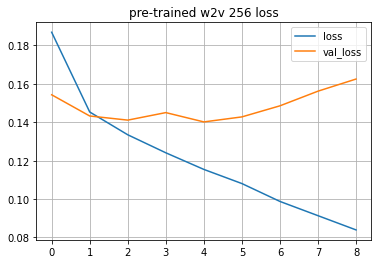

In [ ]:
hist_w2v[['loss', 'val_loss']].plot()
plt.title('pre-trained w2v 256 loss')
plt.grid()
plt.show()

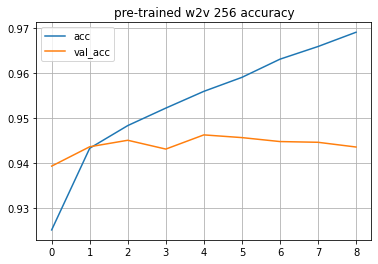

In [ ]:
hist_w2v[['acc', 'val_acc']].plot()
plt.title('pre-trained w2v 256 accuracy')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = best_model_w2v.evaluate(X_test, y_test, verbose=1)
pred = best_model_w2v.predict(X_test)
print('model accuracy:', test_acc)
print('model loss:', test_loss)

5469/5469 [==============================] - 35s 6ms/step - loss: 0.1380 - acc: 0.9470
model accuracy: 0.9470487236976624
model loss: 0.13801932334899902


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)

In [ ]:
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])

# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

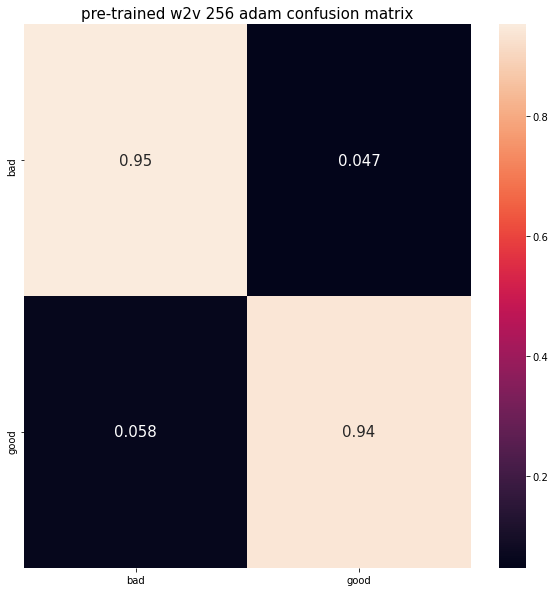

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('pre-trained w2v 256 adam confusion matrix', fontsize=15)
plt.show()

### 512

In [ ]:
model_w2v_512 = Sequential()
model_w2v_512.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))
model_w2v_512.add(Bidirectional(LSTM(100)))
model_w2v_512.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model13.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model_w2v_512.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history_w2v_512 = model_w2v_512.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=512, validation_split=0.2)

Epoch 1/100
821/821 [==============================] - 59s 68ms/step - loss: 0.2544 - acc: 0.8932 - val_loss: 0.1577 - val_acc: 0.9378

Epoch 00001: val_acc improved from -inf to 0.93783, saving model to best_model13.h5
Epoch 2/100
821/821 [==============================] - 55s 67ms/step - loss: 0.1524 - acc: 0.9408 - val_loss: 0.1474 - val_acc: 0.9425

Epoch 00002: val_acc improved from 0.93783 to 0.94249, saving model to best_model13.h5
Epoch 3/100
821/821 [==============================] - 55s 67ms/step - loss: 0.1400 - acc: 0.9454 - val_loss: 0.1424 - val_acc: 0.9443

Epoch 00003: val_acc improved from 0.94249 to 0.94425, saving model to best_model13.h5
Epoch 4/100
821/821 [==============================] - 55s 67ms/step - loss: 0.1296 - acc: 0.9499 - val_loss: 0.1420 - val_acc: 0.9446

Epoch 00004: val_acc improved from 0.94425 to 0.94456, saving model to best_model13.h5
Epoch 5/100
821/821 [==============================] - 55s 67ms/step - loss: 0.1236 - acc: 0.9524 - val_loss: 0

In [ ]:
best_model_w2v_512 = load_model('best_model13.h5')
print('accuracy:', best_model_w2v_512.evaluate(X_test, y_test)[1])

5469/5469 [==============================] - 35s 6ms/step - loss: 0.1403 - acc: 0.9461
accuracy: 0.9461172223091125


In [ ]:
hist_w2v_512 = pd.DataFrame(history_w2v_512.history)

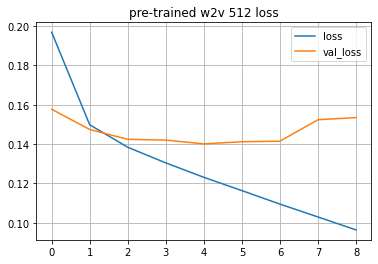

In [ ]:
hist_w2v_512[['loss', 'val_loss']].plot()
plt.title('pre-trained w2v 512 loss')
plt.grid()
plt.show()

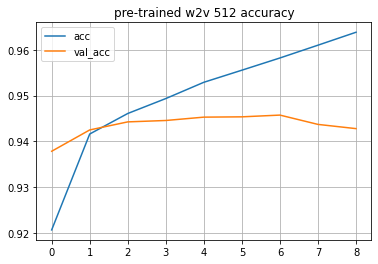

In [ ]:
hist_w2v_512[['acc', 'val_acc']].plot()
plt.title('pre-trained w2v 512 accuracy')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = best_model_w2v_512.evaluate(X_test, y_test, verbose=1)
pred = best_model_w2v_512.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 34s 6ms/step - loss: 0.1403 - acc: 0.9461
model accuracy: 0.9461172223091125


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])
# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

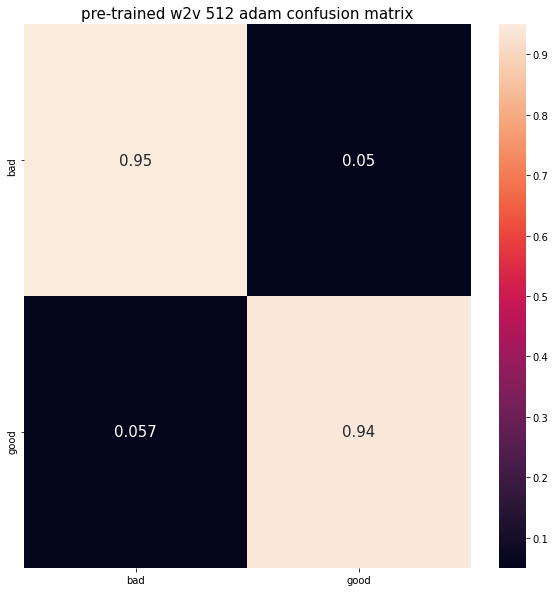

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('pre-trained w2v 512 adam confusion matrix', fontsize=15)
plt.show()